In [ ]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.metrics import * 
from sklearn.model_selection import train_test_split
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

import torch.nn as nn
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import datasets, models, transforms

import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.models as models
from torchsummary import summary
from torch.utils.data import RandomSampler
from torchvision.utils import make_grid
%matplotlib inline




In [ ]:
#Downloading the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model= models.vgg16(pretrained=True)
torch.save(model.state_dict(), 'vgg16_pretrained.ckpt')

#Modifying the last classifier layer to output 450 classes instead of 1000
model.classifier[6] = nn.Linear(4096, 450 , bias = True)

In [ ]:
## Functions for freezing and unfreezing relavant parts of the architecture.
def freeze_backbone(model):
    for param in model.features.parameters():
        param.requires_grad = False

def freeze_head(model):
    for param in model.classifier.parameters():
        param.requires_grad = False

def unfreeze_backbone(model):
    for param in model.features.parameters():
        param.requires_grad = True

def unfreeze_head(model):
    for param in model.classifier.parameters():
        param.requires_grad = True

In [ ]:
#Freezing the entire NN
unfreeze_backbone(model)
unfreeze_head(model)

In [ ]:
import os
train_dir = "100-birds/train"
test_dir = "100-birds/test"
val_dir = "100-birds/valid"
class_dict = {}
classes_1 = os.listdir(train_dir)
#Creating a dictionary of the classes and their corresponding img count
for class_name in classes_1:
    try:
        temp_path = os.path.join(train_dir, class_name)
        class_dict[class_name] = len(os.listdir(temp_path))
    except:
        pass
#Creating a dataframe of the classes and their corresponding img count
classes = pd.DataFrame(class_dict.items(), columns = ['class_name', 'count'])
#Sorting the dataframe by the count of the images
classes = classes.sort_values(by = 'count', ascending = False)
classes.reset_index(drop = True, inplace = True)  
#basic statistics of the classes  
stats = classes.describe()
display(stats)
#Defining outliers as classes that surpass the 75th percentile +- 1.5*IQR
high_ourliers = classes["class_name"][classes["count"] > stats["count"]["75%"] + 1.5 * (stats["count"]["75%"] - stats["count"]["25%"])].values
low_ourliers = classes["class_name"][classes["count"] < stats["count"]["25%"] - 1.5 * (stats["count"]["75%"] - stats["count"]["25%"])].values
#Print the results
print("High outliers: ", high_ourliers)
print("Low outliers: ", low_ourliers)

,count
count,450.000000
mean,156.946667
std,17.408029
min,130.000000
25%,144.000000
50%,155.000000
75%,163.000000
max,248.000000


High outliers:  ['HOUSE FINCH' 'OVENBIRD' 'D-ARNAUDS BARBET' 'SWINHOES PHEASANT'
 'WOOD DUCK' 'CASPIAN TERN' 'OYSTER CATCHER' 'DARK EYED JUNCO'
 'RED TAILED HAWK' 'VIOLET GREEN SWALLOW' 'SORA' 'CRIMSON SUNBIRD'
 'CAMPO FLICKER' 'MARABOU STORK' 'RED BEARDED BEE EATER' 'NORTHERN PARULA'
 'BANDED BROADBILL' 'RAZORBILL' 'VARIED THRUSH' 'SPOONBILL']
Low outliers:  []


In [ ]:
model.to(device)
summary(model,(3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.CenterCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
valid_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)
print(len(train_data),len(valid_data),len(test_data))
#Setting the corrosponding labels with their classes
idx_to_class = {v: k for k, v in train_data.class_to_idx.items()}


70626 2250 2250


In [ ]:
# define dataloader parameters
batch_size = 20
num_workers= 0

# instantiate data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True )

valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

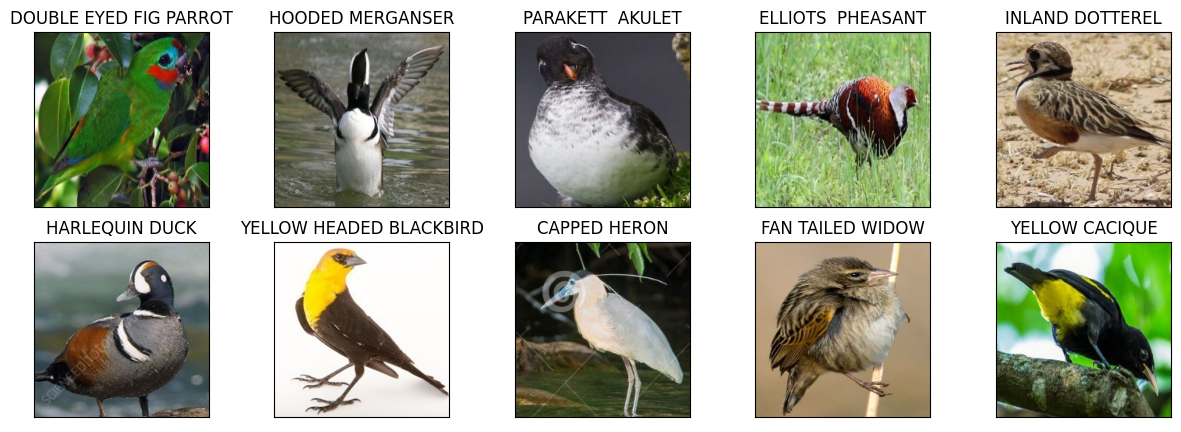

In [ ]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15,5))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(idx_to_class[labels[idx].item()])

In [ ]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)

In [ ]:
# number of epochs to train the model
n_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
valid_loss_min = np.Inf # track change in validation loss
model.to(device)

for epoch in range(1, n_epochs+1):
    print("epoch number : ",epoch)

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    #Model training 
    count = 0 
    model.train()
    for data, target in train_loader:
        count += len(target)
        if count % 2000 == 0:
            print(count,"/","70000")
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        count += len(target)
        if count % 2000 == 0:
            print(count,"/",len(train_data))
            print(f"train loss at epoch {epoch} and iteration {count/20} : ",train_loss)
    print("train loss : ",train_loss)

    #Model validation
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        data, target = data.to(device) ,target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        valid_loss_min = valid_loss
        
        model_scripted = torch.jit.script(model) # Export to TorchScript
        model_scripted.save('model_scripted.pt') # Save
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "Untitled Folder/model.pt")

epoch number :  1
2000 / 70626
train loss at epoch 1 and iteration 100.0 :  6213.575286865234
4000 / 70626
train loss at epoch 1 and iteration 200.0 :  12382.789373397827
6000 / 70626
train loss at epoch 1 and iteration 300.0 :  18540.79300880432
8000 / 70626
train loss at epoch 1 and iteration 400.0 :  24658.670740127563
10000 / 70626
train loss at epoch 1 and iteration 500.0 :  30749.91108894348
12000 / 70626
train loss at epoch 1 and iteration 600.0 :  36796.980142593384
14000 / 70626
train loss at epoch 1 and iteration 700.0 :  42837.96178817749
16000 / 70626
train loss at epoch 1 and iteration 800.0 :  48840.70252418518
18000 / 70626
train loss at epoch 1 and iteration 900.0 :  54837.191972732544
20000 / 70626
train loss at epoch 1 and iteration 1000.0 :  60781.37519836426
22000 / 70626
train loss at epoch 1 and iteration 1100.0 :  66718.43733787537
24000 / 70626
train loss at epoch 1 and iteration 1200.0 :  72648.94488334656
26000 / 70626
train loss at epoch 1 and iteration 1300.

In [ ]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(450))
class_total = list(0. for i in range(450))
total_preds = []
total_gt = []
model.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    total_preds.append(pred.cpu())
    total_gt.append(target)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    for i in range(batch_size):
        try:
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        except:
            pass

        #Example - turning probabilities back to classes
# >>> a = torch.randn(4, 4)
# >>> a
# tensor([[-1.2360, -0.2942, -0.1222,  0.8475],
#         [ 1.1949, -1.1127, -2.2379, -0.6702],
#         [ 1.5717, -0.9207,  0.1297, -1.8768],
#         [-0.6172,  1.0036, -0.6060, -0.2432]])
# >>> torch.max(a, 1)
# torch.return_types.max(values=tensor([0.8475, 1.1949, 1.5717, 1.0036]), indices=tensor([3, 0, 0, 1]))


# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

acc_dict = {}
for i in range(450):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            idx_to_class[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
        acc_dict[idx_to_class[i]] = {"class_acc":100 * (class_correct[i] / class_total[i])}
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.446606

Test Accuracy of ABBOTTS BABBLER: 60% ( 3/ 5)
Test Accuracy of ABBOTTS BOOBY: 60% ( 3/ 5)
Test Accuracy of ABYSSINIAN GROUND HORNBILL: 100% ( 5/ 5)
Test Accuracy of AFRICAN CROWNED CRANE: 100% ( 5/ 5)
Test Accuracy of AFRICAN EMERALD CUCKOO: 100% ( 5/ 5)
Test Accuracy of AFRICAN FIREFINCH: 80% ( 4/ 5)
Test Accuracy of AFRICAN OYSTER CATCHER: 100% ( 5/ 5)
Test Accuracy of AFRICAN PIED HORNBILL: 20% ( 1/ 5)
Test Accuracy of ALBATROSS: 100% ( 5/ 5)
Test Accuracy of ALBERTS TOWHEE: 60% ( 3/ 5)
Test Accuracy of ALEXANDRINE PARAKEET: 80% ( 4/ 5)
Test Accuracy of ALPINE CHOUGH: 40% ( 2/ 5)
Test Accuracy of ALTAMIRA YELLOWTHROAT: 40% ( 2/ 5)
Test Accuracy of AMERICAN AVOCET: 100% ( 5/ 5)
Test Accuracy of AMERICAN BITTERN: 100% ( 5/ 5)
Test Accuracy of AMERICAN COOT: 100% ( 5/ 5)
Test Accuracy of AMERICAN FLAMINGO: 100% ( 5/ 5)
Test Accuracy of AMERICAN GOLDFINCH: 100% ( 5/ 5)
Test Accuracy of AMERICAN KESTREL: 100% ( 5/ 5)
Test Accuracy of AMERICAN PIPIT: 100% ( 5/ 5)
Test

In [ ]:
acc_df = pd.DataFrame(acc_dict)

In [ ]:
print(acc_df.T["class_acc"].sort_values()[:10])

AVADAVAT                          0.0
BREWERS BLACKBIRD                 0.0
NORTHERN BEARDLESS TYRANNULET    20.0
DARWINS FLYCATCHER               20.0
MANGROVE CUCKOO                  20.0
AFRICAN PIED HORNBILL            20.0
SKUA                             20.0
ASHY STORM PETREL                20.0
BOBOLINK                         20.0
BUFFLEHEAD                       20.0
Name: class_acc, dtype: float64


# Loading the model - and making an inference


In [ ]:
device = torch.device('cpu')
checkpoint = torch.load("/Users/adirserruya/Desktop/PDLC_Assignment_1/model.pt", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Fucntion to retrieve images

In [ ]:
from PIL import Image

def retrieve_image(class_name):
    path = "/Users/adirserruya/Desktop/PDLC_Assignment_1/100-birds/test/" + class_name+"/"
    random = np.random.randint(0, len(os.listdir(path)))
    img = plt.imread(path + os.listdir(path)[random])
    return img

# Retrieving the top 5 prediction images per predictions

BLACK BAZA : Ground Truth
BANDED BROADBILL : Prediction
['BANDED BROADBILL', 'BLACK BAZA', 'HELMET VANGA', 'AFRICAN PIED HORNBILL', 'CRESTED OROPENDOLA'] : Top 5 predictions
SKUA : Ground Truth
BROWN NOODY : Prediction
['BROWN NOODY', 'WHITE NECKED RAVEN', 'AMERICAN COOT', 'SKUA', 'PARAKETT  AKULET'] : Top 5 predictions


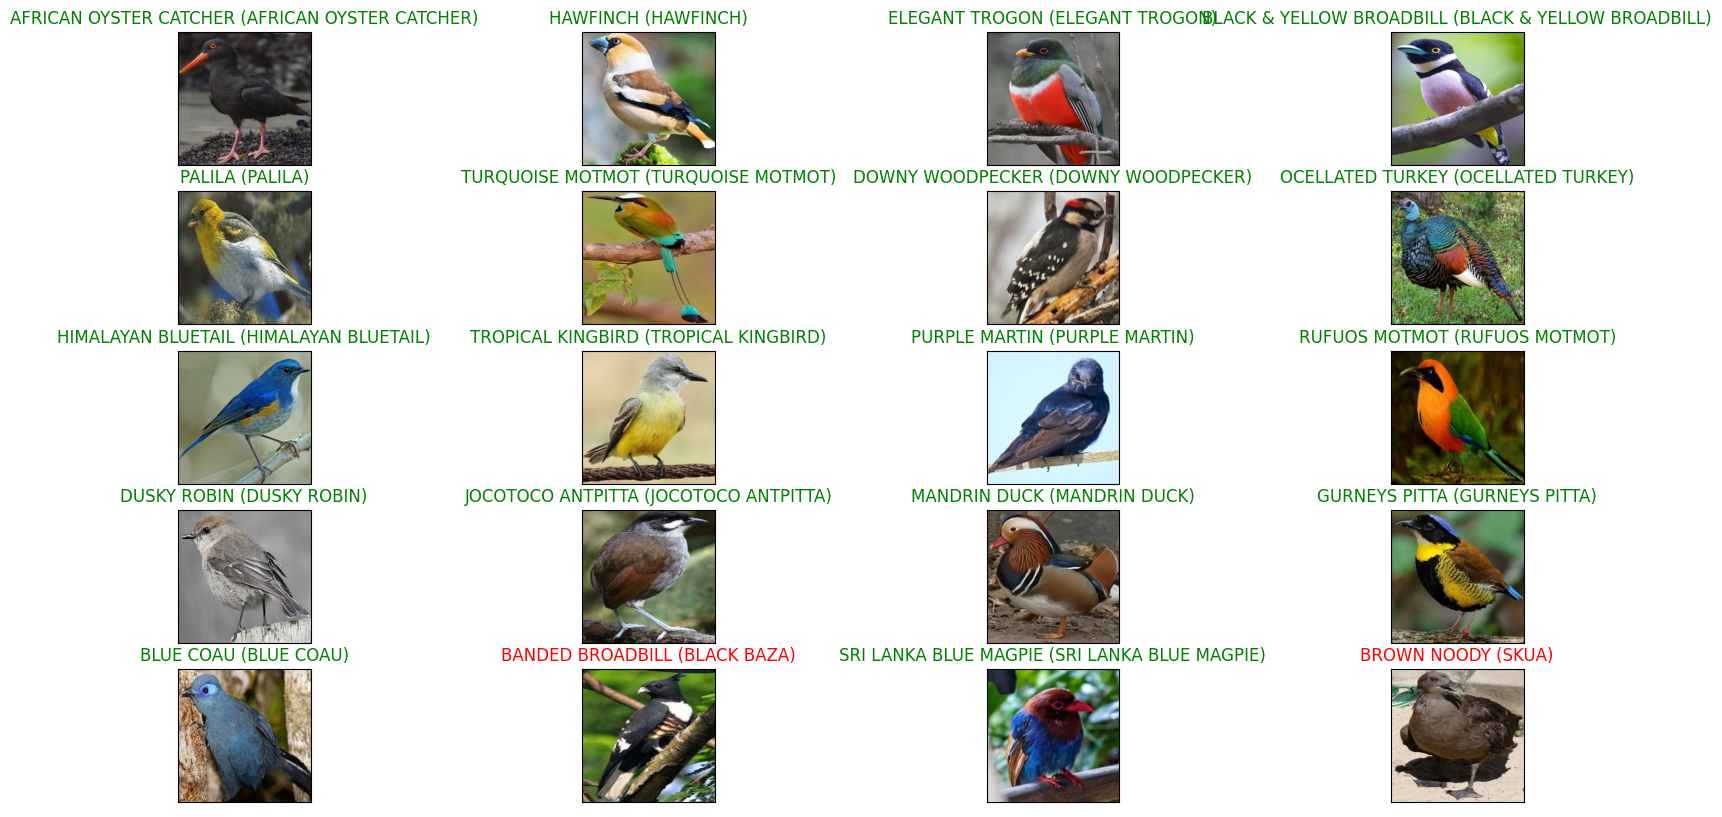

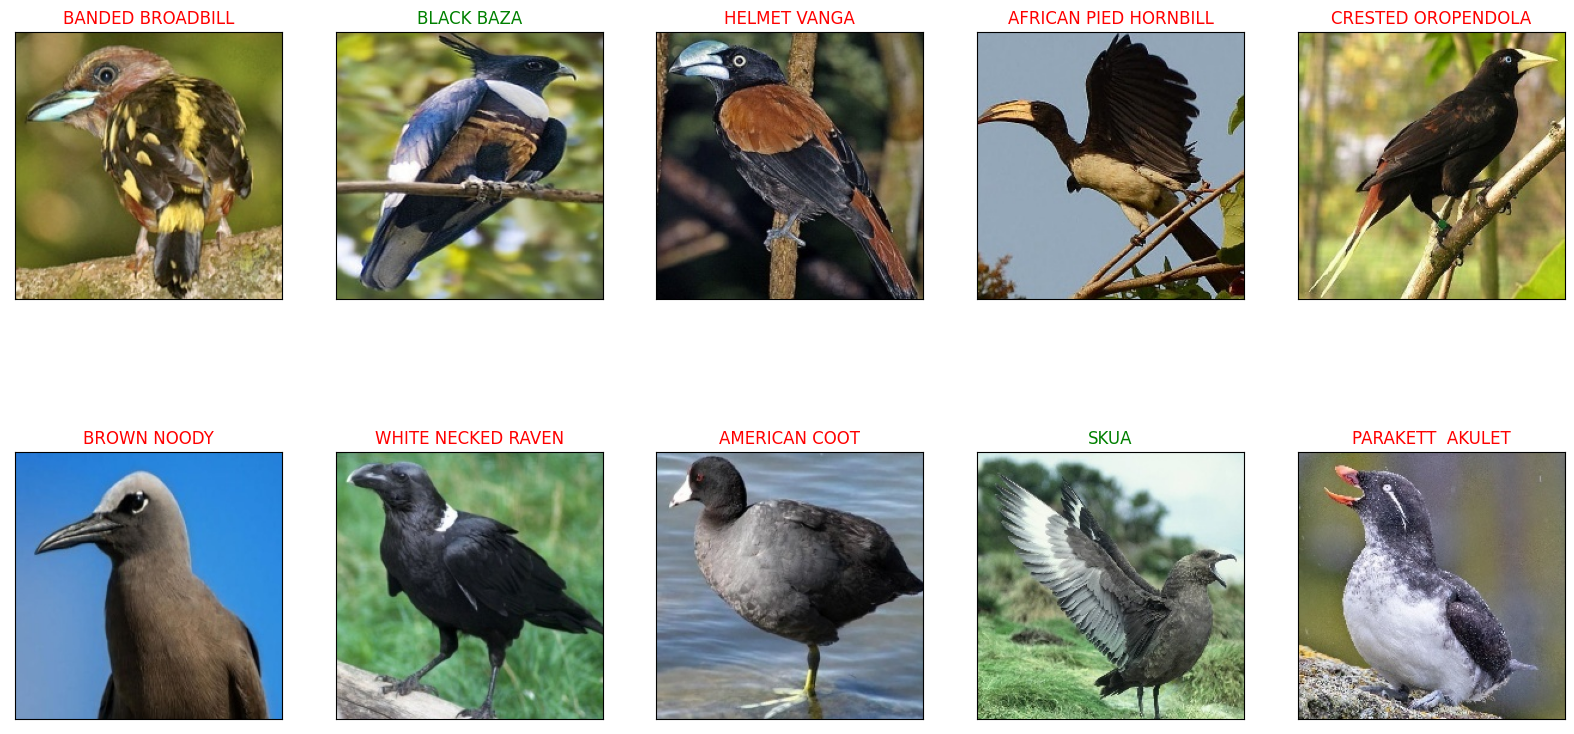

In [ ]:
#plotting correct and incorrect predictions
loader = iter(test_loader)
data , target = next(loader)
data, target = data.to(device), target.to(device)
output = model(data)
class_prob = {}
class_names = {}
predictions = {}
_, pred = torch.max(output, 1)
correct_tensor = pred.eq(target.data.view_as(pred))
correct = np.squeeze(correct_tensor.cpu().numpy())
fig = plt.figure(figsize=(20, 10))
for idx in np.arange(20):
    ax = fig.add_subplot(5, 4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(data[idx].cpu().numpy().squeeze(), (1, 2, 0)))

    ax.set_title("{} ({})".format(str(idx_to_class[pred[idx].item()]), str(idx_to_class[target[idx].item()])),
                 color=("green" if correct[idx]==1 else "red"))
    top_5 = torch.topk(output[idx], 5, largest=True, sorted=True)
    class_prob[idx] = top_5[0].cpu().detach().numpy()
    class_names[idx] = [idx_to_class[i.item()] for i in top_5.indices]
    predictions[idx] = {"pred":idx_to_class[pred[idx].item()],
                         "gt":idx_to_class[target[idx].item()],
                         "top_5":class_names[idx],
                         "top_5_prob":class_prob[idx]}
    

pred_df = pd.DataFrame(predictions)
pred_df = pred_df.T
fig_2 = plt.figure(figsize=(20, 10))
# Wrong predictions
wrong_pred = pred_df[pred_df["pred"] != pred_df["gt"]]
wrong_pred
count = 0

#Every time, the first bird in each row is the false prediction we made
for idx,row in enumerate(wrong_pred.iterrows()):
    print(row[1]["gt"],": Ground Truth")
    print(row[1]["pred"],": Prediction")
    print(row[1]["top_5"] , ": Top 5 predictions")
    for i in row[1]["top_5"]:
        count += 1
        ax = fig_2.add_subplot(len(wrong_pred), 5, count, xticks=[], yticks=[])
        plt.imshow(retrieve_image(i))
        ax.set_title("{}".format(i), color=("green" if i==row[1]["gt"] else "red"))
    